In [26]:
import os
import sys
import random

from pathlib import Path
root = Path('..').resolve()
sys.path.insert(0, str(root))

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

import src.data.augmentation as aug
import src.data.image_processing as ip
import src.attributions.gradcam as gradcam
from src.models.torch import Xception

In [27]:
ckpt = torch.load("out/checkpoints/adver_it0.ckpt", map_location="cpu")
state_dict = ckpt["state_dict"]

new_state = {}
for k,v in state_dict.items():
    name = k.replace("model.", "")
    new_state[name] = v

model = Xception(num_classes=2)
model.load_state_dict(new_state)
model.eval();
# model.cuda()

/tmp/ipykernel_936033/1975283738.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("out/checkpoints/adver_it0.ckpt", map_location="cpu")
/home/federici/m

In [28]:
size = 64 * 8
aug_config = aug.AugConfig( 
    resize_width = size,  # 512 = 64 * 8 
    resize_height = size, 
    mean = [0.2872, 0.2872, 0.4595],
    std = [0.1806, 0.1806, 0.2621]
)

val_compose = aug.to_compose(aug_config, stage="val")

In [29]:
img_path = "data/train/pos/03cb6a_20191204T073021_20191204T073211_mos_rgb.png"
train_dir = "data/train"
category = 'pos' # random.choice(['pos', 'neg'])
chosen_image = random.choice(os.listdir(os.path.join(train_dir, category)))
# img_path = os.path.join(train_dir, category, chosen_image)
img = Image.open(img_path)
img_tens = val_compose(img).unsqueeze(0)
img_tens.shape

torch.Size([1, 3, 512, 512])

In [30]:
# tens = torch.rand(1, 2)
# print(tens)
# print(torch.argmax(tens).item())

In [31]:
with torch.no_grad():
    print(torch.argmax(model(img_tens)).item())

1


(-0.5, 511.5, 511.5, -0.5)

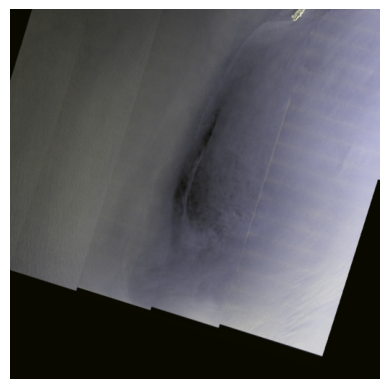

In [32]:
plt.imshow(ip.normalize_image_to_range(img_tens.squeeze(0).permute(1, 2, 0).cpu().numpy()))
plt.axis("off")

Pos logit: 1.608694076538086 -> Pred: 1


Pos logit: -6.232144832611084 -> Pred: 0
Pos logit: -7.914182662963867 -> Pred: 0


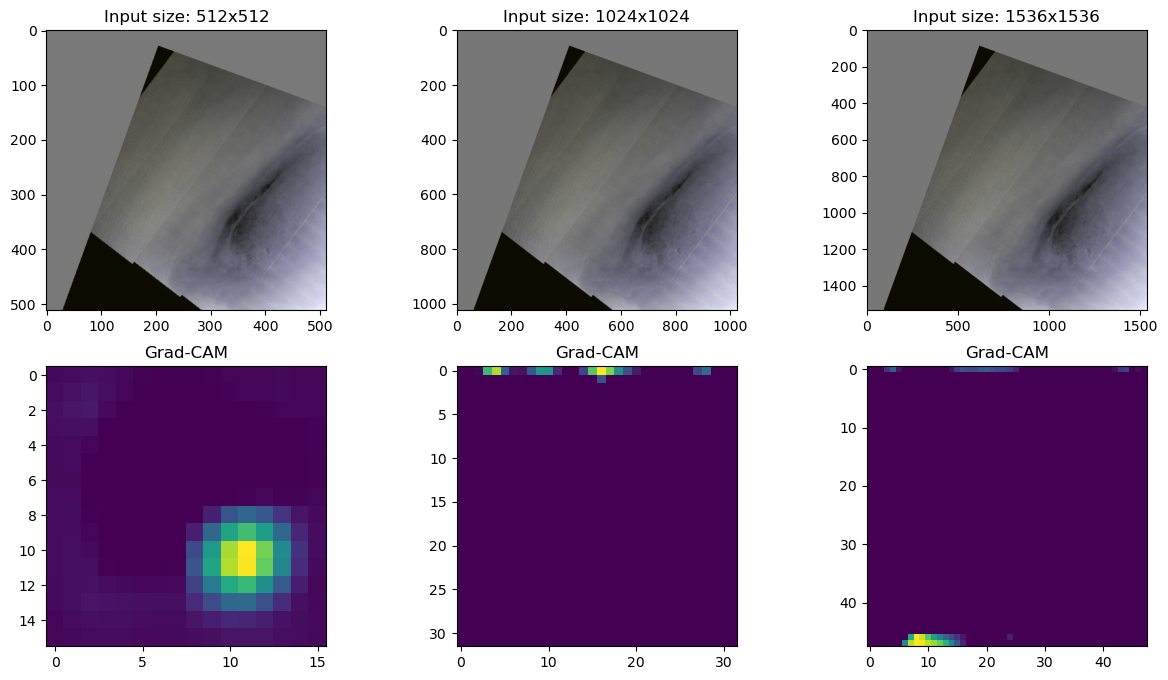

In [33]:
gc = gradcam.GradCAM(model, device="cpu")

sizes = [512, 512*2, 512*3]
resized_heatmaps = []
resized_heatmaps_bil = []
ncols = len(sizes)
nrows = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, nrows*4))
for i, s in enumerate(sizes):
    aug_config = aug.AugConfig( 
        resize_width = s,  # 512 = 64 * 8 
        resize_height = s, 
        mean = [0.2872, 0.2872, 0.4595],
        std = [0.1806, 0.1806, 0.2621],
    )
    
    val_compose = aug.to_compose(aug_config, stage="train")
    
    img_tens = val_compose(img).unsqueeze(0)
    do_augment = True
    if do_augment:
        angle = 20
        translate = [s*0.2, s*0.2] 
        img_tens = TF.affine(
            img_tens,
            angle = angle,
            translate = translate,
            scale = 1.0,
            shear = [0.0, 0.0]
        )
    
    logits = model(img_tens)[0]
    logit_pos = logits[1].item()
    pred = torch.argmax(logits).item()
    print(f"Pos logit: {logit_pos} -> Pred: {pred}")
    heatmap = gc.generate_heatmap(img_tens, target_class=1)
    ax[0, i].imshow(
        ip.normalize_image_to_range(img_tens.squeeze(0).permute(1, 2, 0).cpu().numpy())
    )
    ax[0, i].set_title(f"Input size: {s}x{s}")
    ax[1, i].imshow(heatmap)
    ax[1, i].set_title("Grad-CAM")
    resized_heatmap = F.interpolate(
        heatmap.unsqueeze(0).unsqueeze(0), size=(512, 512), mode="nearest", antialias=False
    ).squeeze(0).squeeze(0)
    resized_heatmap_bil = F.interpolate(
        heatmap.unsqueeze(0).unsqueeze(0), size=(512, 512), mode="bilinear", antialias=False
    ).squeeze(0).squeeze(0)
    resized_heatmaps.append(resized_heatmap)
    resized_heatmaps_bil.append(resized_heatmap_bil)
    # ax[2, i].imshow(resized_heatmap_bil)
    # ax[2, i].set_title("Resized to 512x512 (Bilinear int.)")

In [34]:
H = torch.stack(resized_heatmaps, dim=0)
H_bil = torch.stack(resized_heatmaps_bil, dim=0)
H_bil.shape

torch.Size([3, 512, 512])

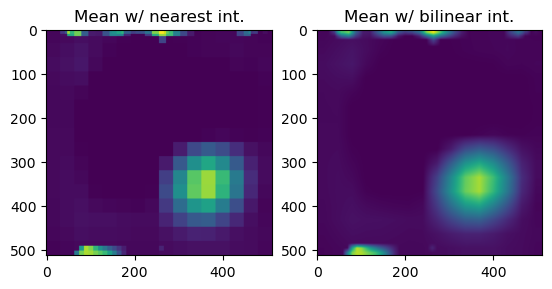

In [35]:
fig, ax = plt.subplots(1, 2)
pixel_mean = H.mean(dim=0)
ax[0].set_title("Mean w/ nearest int.")
ax[0].imshow(pixel_mean)
pixel_mean_bil = H_bil.mean(dim=0)

norm = True
if norm:
    pmin = pixel_mean_bil.min()
    pmax = pixel_mean_bil.max()
    denom = (pmax - pmin).clamp_min(1e-6)
    pixel_mean_bil = (pixel_mean_bil - pmin) / denom

ax[1].set_title("Mean w/ bilinear int.")
ax[1].imshow(pixel_mean_bil)

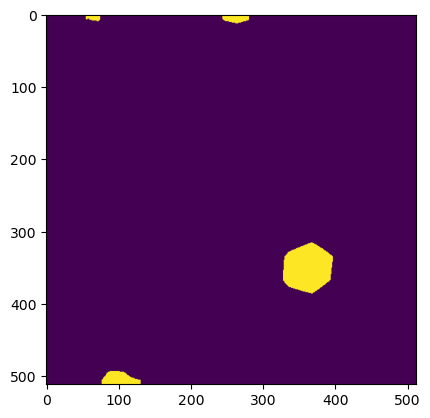

In [36]:
thr_pmean = (pixel_mean_bil > 0.7)
plt.imshow(thr_pmean)

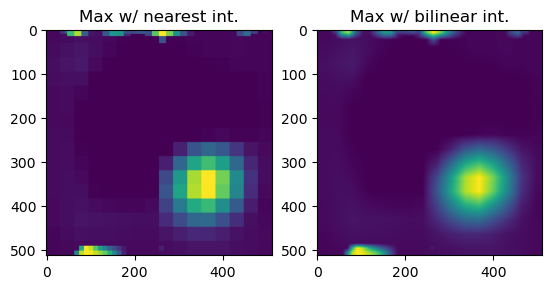

In [37]:
fig, ax = plt.subplots(1, 2)
pixel_max, _ = H.max(dim=0)
ax[0].set_title("Max w/ nearest int.")
ax[0].imshow(pixel_max)
pixel_max_bil, _ = H_bil.max(dim=0)
ax[1].set_title("Max w/ bilinear int.")
ax[1].imshow(pixel_max_bil)